![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FApplied+ML%2FSolution+Prototypes%2Fdocument-processing&file=4-document-similarity.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20ML/Solution%20Prototypes/document-processing/4-document-similarity.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FApplied%2520ML%2FSolution%2520Prototypes%2Fdocument-processing%2F4-document-similarity.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/Applied%20ML/Solution%20Prototypes/document-processing/4-document-similarity.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Applied%20ML/Solution%20Prototypes/document-processing/4-document-similarity.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# Document Simlarity With Embeddings

Write up here
include link to math of similarity [Math of Similarity](../../../Applied%20GenAI/Embeddings/The%20Math%20of%20Similarity.ipynb)
docs pages:
BigQuery [Introduction to vector search](https://cloud.google.com/bigquery/docs/vector-search-intro)
BigQuery [VECTOR_SEARCH](https://cloud.google.com/bigquery/docs/reference/standard-sql/search_functions#vector_search) function
PCA:
- [CREATE MODEL statement for PCA models](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-pca)


## Setup

Note that this notebook expects to use a local virtual environment with the `./requirements.txt` installed.  

A potential workaround if using this notebook standalone is running:

>```python
>pip install -r requirements.txt
>```

And then restart the kernel.

In [127]:
# package imports for this work
import os, subprocess#, io, re

from IPython.display import display, Image, Markdown
import ipywidgets
import fitz # PyMuPDF
import matplotlib.pyplot as plt
import seaborn as sns

from google.cloud import storage
from google.cloud import bigquery
import vertexai.vision_models

In [2]:
# what project are we working in?
PROJECT_ID = subprocess.run(['gcloud', 'config', 'get-value', 'project'], capture_output=True, text=True, check=True).stdout.strip()
PROJECT_ID

'statmike-mlops-349915'

In [3]:
LOCATION = 'us-central1'

SERIES = 'applied-ml-solution-prototypes'
EXPERIMENT = 'document-processing'
GCS_BUCKET = PROJECT_ID # bucket has same name as project here

In [4]:
# setup google cloud storage client
gcs = storage.Client(project = PROJECT_ID)
bucket = gcs.bucket(GCS_BUCKET)

# setup google cloud bigquery client
bq = bigquery.Client(project = PROJECT_ID)

# load the bigquery magics for jupyter with:
%load_ext bigquery_magics

---
## Review The Data Source

So far this project has:
- Built a custome data extractor with Document AI
- Created an object table in BigQuery that maps to documents stored in GCS
- Created a new table by processing the documents in the object table with the `ML.PROCESS_DOCUMENTS` function that uses the custom parser built with Document AI
  - Augmented the table with generated image embeddings for the documents using Vertex AI hosted embeddings models with the `ML.GENERATE_EMBEDDING` function

Before we procedd to work with these embedding let's review the data so far:


In [5]:
%%bigquery
SELECT *
FROM `statmike-mlops-349915.solution_prototype_document_processing.known_authenticity`
LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

,ml_process_document_result,ml_process_document_status,vendor_name,vendor_address,company_name,company_address,invoice_id,invoice_total,line_item,uri,updated,vendor,embedding
0,"{""entities"":[{""confidence"":1,""id"":""0"",""mention...",,None,None,BioTech Innovations Corp,"666 Genome Way\nSan Diego, CA 92121",KD-2024-0315,$37108.50,"[{'item_sku': 'WEB- DEV- 001', 'item_descripti...",gs://statmike-mlops-349915/applied-ml-solution...,2025-04-23 20:53:37.673000+00:00,vendor_2,"[0.0089465566, 0.0536203124, 0.0614382476, -0...."
1,"{""entities"":[{""confidence"":1,""id"":""0"",""mention...",,None,None,HealthAI Innovations,"123 Main Street\nSan Francisco, CA 94111",INV-2024-0315,$21924.00,"[{'item_sku': 'CSD- 001', 'item_description': ...",gs://statmike-mlops-349915/applied-ml-solution...,2025-04-23 20:53:35.765000+00:00,vendor_2,"[0.0121024447, 0.0618715286, 0.0657297298, -0...."
2,"{""entities"":[{""confidence"":1,""id"":""1"",""propert...",,None,None,GlobalMed Health,"123 Serene Drive\nSan Diego, CA 92101",INV-2024-1122,$23600.00,"[{'item_sku': 'WEB- DEV- 001', 'item_descripti...",gs://statmike-mlops-349915/applied-ml-solution...,2025-04-23 20:53:35.038000+00:00,vendor_2,"[0.0141071267, 0.0521478951, 0.0623387806, -0...."
3,"{""entities"":[{""confidence"":1,""id"":""0"",""mention...",,None,None,Swift Logistics Solutions,"987 Elm Street\nDallas, TX 75201",KD-2024-0722,$19920.00,"[{'item_sku': 'WEB- DEV- 001', 'item_descripti...",gs://statmike-mlops-349915/applied-ml-solution...,2025-04-23 20:53:39.182000+00:00,vendor_2,"[0.0090936739, 0.0496088825, 0.0622638054, -0...."
4,"{""entities"":[{""confidence"":1,""id"":""1"",""propert...",,None,None,Style Forward Retail,"99 Fashion Blvd Los Angeles, CA 90015",INV-2024-1105,$34800.00,"[{'item_sku': None, 'item_description': 'Web D...",gs://statmike-mlops-349915/applied-ml-solution...,2025-04-23 20:52:52.221000+00:00,vendor_12,"[0.0019979002, 0.0560282543, 0.0625561327, -0...."


In [11]:
%%bigquery
# document count per vendor:
SELECT vendor, count(*) as document_count
FROM `statmike-mlops-349915.solution_prototype_document_processing.known_authenticity`
GROUP BY vendor

Query is running:   0%|          |

Downloading:   0%|          |

,vendor,document_count
0,vendor_2,16
1,vendor_12,22
2,vendor_7,29
3,vendor_0,19
4,vendor_10,22
5,vendor_13,19
6,vendor_5,16
7,vendor_6,19
8,vendor_9,23
9,vendor_3,19


In [12]:
%%bigquery temp
# review an embedding:
SELECT embedding
FROM `statmike-mlops-349915.solution_prototype_document_processing.known_authenticity`
LIMIT 1

Query is running:   0%|          |

Downloading:   0%|          |

In [14]:
temp['embedding'][0]

array([ 0.00894656,  0.05362031,  0.06143825, ...,  0.01621641,
       -0.03250906, -0.01569333], shape=(1408,))

---
## Document Similarity With Embeddings

The embeddings can be used to calculate similarity via the distance between two embeddings. Two documents from the same vendor should be closer to each other than two documents from different vendors.  

This is made possible with the [VECTOR_SEARCH](https://cloud.google.com/bigquery/docs/reference/standard-sql/search_functions#vector_search) function in BigQuery.

In [44]:
%%bigquery
# compare a document to all documents and choose closest matches:
SELECT
    SPLIT(query.uri, '/')[7] as query, 
    SPLIT(base.uri, '/')[7] as match,
    distance
FROM VECTOR_SEARCH(
    # The base table and column to search for neighbors in:
    (SELECT uri, embedding FROM `statmike-mlops-349915.solution_prototype_document_processing.known_authenticity`),
    'embedding',
    # The query table and column to search with
    (SELECT uri, embedding FROM `statmike-mlops-349915.solution_prototype_document_processing.known_authenticity` LIMIT 1),
    'embedding',
    # options
    top_k => 5,
    distance_type => 'DOT_PRODUCT'
)

Query is running:   0%|          |

Downloading:   0%|          |

,query,match,distance
0,vendor_2_invoice_4.pdf,vendor_2_invoice_4.pdf,-1.000000
1,vendor_2_invoice_4.pdf,vendor_2_invoice_0.pdf,-0.985250
2,vendor_2_invoice_4.pdf,vendor_2_invoice_2.pdf,-0.985235
3,vendor_2_invoice_4.pdf,vendor_2_invoice_11.pdf,-0.977864
4,vendor_2_invoice_4.pdf,vendor_2_invoice_8.pdf,-0.976577


**Interpretation**

This query picked a single document to search with from the full table with the `LIMIT 1`.  It then found the closest 5 documents to the chosen document from the full table.  The distance function shows the similarity of the top 5 matches where lower is closer.  The top match has the lowest possible distance of -1 here and it is the identical document that was chosen to search with.  The other matches are all very close to -1 and notice they are all from the same vendor.

> **NOTE** on `DOT_PRODUCT`:  The dot product of two identical vectors is 1 but is reported as -1 by the `VECTOR_SEARCH` function in BigQuery.  This is actually -1 * dot product and aligns the similarity metrics across each distance type so that lower is better and makes the sorting consistent.

### Classify A Document Based on Closest Vendor

Pick a document from any vendor and then compare it to all the documents and then average the distance by vendor to see which vendor the document is closest to typically.  

**NOTE:** This might not be the most efficient approach as the number of documents grow.  The next section will look at a way to compute a representation of each vendor as a single point of comparison.

In [94]:
%%bigquery classify_results
# For a query document(s) calculate the average distance to each vendors documents
SELECT
    SPLIT(query.uri, '/')[7] as query, 
    base.vendor,
    AVG(distance) as avg_distance
FROM VECTOR_SEARCH(
    # The base table and column to search for neighbors in:
    (SELECT vendor, embedding FROM `statmike-mlops-349915.solution_prototype_document_processing.known_authenticity`),
    'embedding',
    # The query table and column to search with
    (SELECT uri, embedding FROM `statmike-mlops-349915.solution_prototype_document_processing.known_authenticity` LIMIT 1),
    'embedding',
    # options
    top_k => -1,
    distance_type => 'DOT_PRODUCT'
)
GROUP BY query, vendor
ORDER BY avg_distance

Query is running:   0%|          |

Downloading:   0%|          |

In [95]:
classify_results

,query,vendor,avg_distance
0,vendor_2_invoice_4.pdf,vendor_2,-0.958956
1,vendor_2_invoice_4.pdf,vendor_4,-0.901225
2,vendor_2_invoice_4.pdf,vendor_12,-0.899433
3,vendor_2_invoice_4.pdf,vendor_9,-0.889482
4,vendor_2_invoice_4.pdf,vendor_14,-0.880970
5,vendor_2_invoice_4.pdf,vendor_13,-0.876974
6,vendor_2_invoice_4.pdf,vendor_11,-0.876786
7,vendor_2_invoice_4.pdf,vendor_5,-0.875411
8,vendor_2_invoice_4.pdf,vendor_8,-0.871013
9,vendor_2_invoice_4.pdf,vendor_10,-0.862712


**Interpretation**

Similar to the last query this one selects a single document and then compares it to all other documents in order to select the top matches.  This time the number of matches is defined as `-1` indicating it should return as many matches as comparisions - all documents.  Then the query averages the distance with a `GROUP_BY` vendor.  This makes comparing the document to each vendor possible and we note that the document most closly matches with the vendor it is from. Then it has varying further distances form other vendors.  

**Visual Comparison**

Let's retrieve the query document and a document from the next closest vendor and the furtherest vendor and see them side-by-side.

In [96]:
query_doc = classify_results['query'][0][:-4]+'.png'
query_vendor = classify_results['vendor'][0]
next_vendor = classify_results['vendor'][1]
far_vendor = list(classify_results['vendor'])[-1]

In [97]:
query_doc, query_vendor, next_vendor, far_vendor

('vendor_2_invoice_4.png', 'vendor_2', 'vendor_4', 'vendor_3')

In [98]:
def compare_classify_results(query_doc, query_vendor, next_vendor,  far_vendor):
    bucket = gcs.bucket(GCS_BUCKET)
    blob_prefix = f"{SERIES}/{EXPERIMENT}/"
    query_blob = bucket.blob(blob_prefix + f"{query_vendor}/invoices/{query_doc}")
    next_blob = bucket.blob(blob_prefix + f"{next_vendor}/invoices/{next_vendor}_invoice_0.png")
    far_blob = bucket.blob(blob_prefix + f"{far_vendor}/invoices/{far_vendor}_invoice_0.png")

    query_image_bytes = ipywidgets.Image(value= query_blob.download_as_bytes(), format = 'png', width = 400)
    next_image_bytes = ipywidgets.Image(value= next_blob.download_as_bytes(), format = 'png', width = 400)
    far_image_bytes = ipywidgets.Image(value= far_blob.download_as_bytes(), format = 'png', width = 400)

    return display(
        ipywidgets.HBox(
            [
                ipywidgets.VBox([ipywidgets.HTML(value = f"<div style='text-align: center; margin-bottom: 5px;'><b>Query Document</b></div>"), query_image_bytes], layout = {'align_items': 'center'}),
                ipywidgets.VBox([ipywidgets.HTML(value = f"<div style='text-align: center; margin-bottom: 5px;'><b>Next Closest Vendor</b></div>"), next_image_bytes], layout = {'align_items': 'center'}),
                ipywidgets.VBox([ipywidgets.HTML(value = f"<div style='text-align: center; margin-bottom: 5px;'><b>Farthest Vendor</b></div>"), far_image_bytes], layout = {'align_items': 'center'})
            ],
            layout = {'justify_content': 'space-around'}
        )
    )

compare_classify_results(query_doc, query_vendor, next_vendor, far_vendor)

### Classify A Document Based On Vendor Centroids

By Averaging the embeddings for each vendor we can create a centroid for the vendor.  Then documents can be compared to these centroids rather than all documents.

This is done by first creating a derived table of average embeddings for each vendor.

In [104]:
%%bigquery
CREATE OR REPLACE TABLE `statmike-mlops-349915.solution_prototype_document_processing.known_authenticity_vendor_info`
AS
WITH
    UnnestedEmbeddings AS (
        SELECT vendor, embedding_element, element_offset
        FROM `statmike-mlops-349915.solution_prototype_document_processing.known_authenticity`,
            UNNEST(embedding) AS embedding_element WITH OFFSET AS element_offset
    ),
    AveragedElements AS (
        SELECT vendor, element_offset, AVG(embedding_element) as avg_element
        FROM UnnestedEmbeddings
        GROUP BY vendor, element_offset
    )
SELECT vendor, ARRAY_AGG(avg_element ORDER BY element_offset ASC) AS average_embedding
FROM AveragedElements
GROUP BY vendor

Query is running:   0%|          |

""


Now calculate the distance for a document to each of the vendors average embedding:

In [105]:
%%bigquery classify_results
# for query document(s) calcualte the distance to each vendors average embedding
SELECT
    SPLIT(query.uri, '/')[7] as query, 
    base.vendor,
    distance
FROM VECTOR_SEARCH(
    # The base table and column to search for neighbors in:
    (SELECT vendor, average_embedding FROM `statmike-mlops-349915.solution_prototype_document_processing.known_authenticity_vendor_info`),
    'average_embedding',
    # The query table and column to search with
    (SELECT uri, embedding FROM `statmike-mlops-349915.solution_prototype_document_processing.known_authenticity` LIMIT 1),
    'embedding',
    # options
    top_k => -1,
    distance_type => 'DOT_PRODUCT'
)
ORDER BY distance

Query is running:   0%|          |

Downloading:   0%|          |

In [106]:
classify_results

,query,vendor,distance
0,vendor_2_invoice_4.pdf,vendor_2,-0.958956
1,vendor_2_invoice_4.pdf,vendor_4,-0.901225
2,vendor_2_invoice_4.pdf,vendor_12,-0.899433
3,vendor_2_invoice_4.pdf,vendor_9,-0.889482
4,vendor_2_invoice_4.pdf,vendor_14,-0.880970
5,vendor_2_invoice_4.pdf,vendor_13,-0.876974
6,vendor_2_invoice_4.pdf,vendor_11,-0.876786
7,vendor_2_invoice_4.pdf,vendor_5,-0.875411
8,vendor_2_invoice_4.pdf,vendor_8,-0.871013
9,vendor_2_invoice_4.pdf,vendor_10,-0.862712


In [107]:
query_doc = classify_results['query'][0][:-4]+'.png'
query_vendor = classify_results['vendor'][0]
next_vendor = classify_results['vendor'][1]
far_vendor = list(classify_results['vendor'])[-1]

compare_classify_results(query_doc, query_vendor, next_vendor, far_vendor)

---
## Re-Dimensionalize Embeddings For Documents

It is difficult to visualize embeddings due to the high dimensionality, over 1400 here.  We can first train a redimensionalized version using a technique like [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) or [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) to 2 dimensions and then plot results.  

Here we will use PCA directly within BigQuery for convenience.  BigQuery offers a [wide range](https://cloud.google.com/bigquery/docs/e2e-journey) of options to train, evaluate and serve models for supervised, unsupervised, and forecasting use cases.

The PCA model will create new dimensions that are orthogonal.  The trained PCA model can also be use to predict where new documents would be placed in the re-dimensionalize space.  It can also serve as an anomaly detection layer when used to detect new records that have errors.

### BigQuery ML - Create PCA Model

Directly in BigQuery we will use the `CREATE MODEL` statement to create a PCA model that learning a 2-demensional version of the embedding - [The CREATE MODEL statement for PCA models](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-pca).

In [109]:
%%bigquery
CREATE OR REPLACE MODEL `statmike-mlops-349915.solution_prototype_document_processing.pca_known_authentic`
    OPTIONS(
        model_type = 'PCA',
        num_principal_components = 2
    )
    AS
    SELECT embedding
    FROM `statmike-mlops-349915.solution_prototype_document_processing.known_authenticity`

Query is running:   0%|          |

""


#### Evalaute The Model

While the model only has 2 components versus the more that 1400 of the embedding it still explains > 86% of the variance:

In [110]:
%%bigquery
SELECT * FROM ML.EVALUATE(MODEL `statmike-mlops-349915.solution_prototype_document_processing.pca_known_authentic`)

Query is running:   0%|          |

Downloading:   0%|          |

,total_explained_variance_ratio
0,0.867222


#### Use The Model To Predict The Re-Dimensionalized Values

There are two ways to do this:
- [ML.PREDICT](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-predict#pca_models) returns the predicted value for each principal component
- [ML.GENERATE_EMBEDDING](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-generate-embedding#pca) returns the predicted values in the form of a vector (array) in the column `ml_generate_embedding_result).  Note these are the same values as ML.PREDICT.

In [111]:
%%bigquery
SELECT *
FROM ML.PREDICT(
    MODEL `statmike-mlops-349915.solution_prototype_document_processing.pca_known_authentic`,
    (SELECT embedding FROM `statmike-mlops-349915.solution_prototype_document_processing.known_authenticity` LIMIT 1)
)

Query is running:   0%|          |

Downloading:   0%|          |

,principal_component_1,principal_component_2
0,0.937391,-0.046467


In [112]:
%%bigquery
SELECT *
FROM ML.GENERATE_EMBEDDING(
    MODEL `statmike-mlops-349915.solution_prototype_document_processing.pca_known_authentic`,
    (SELECT embedding FROM `statmike-mlops-349915.solution_prototype_document_processing.known_authenticity` LIMIT 1)
)

Query is running:   0%|          |

Downloading:   0%|          |

,ml_generate_embedding_result,embedding
0,"[0.9373912663536372, -0.046467204793839756]","[0.0089465566, 0.0536203124, 0.0614382476, -0...."


### Get Predicted Values For All Documents With Known Authenticity

In [129]:
%%bigquery pca_predictions
SELECT vendor, ml_generate_embedding_result as pca_embedding
FROM ML.GENERATE_EMBEDDING(
    MODEL `statmike-mlops-349915.solution_prototype_document_processing.pca_known_authentic`,
    (SELECT vendor, embedding FROM `statmike-mlops-349915.solution_prototype_document_processing.known_authenticity`)
)

Query is running:   0%|          |

Downloading:   0%|          |

In [130]:
pca_predictions

,vendor,pca_embedding
0,vendor_3,"[0.8718115968978105, 0.36923955569086336]"
1,vendor_4,"[0.9364098419153561, -0.09344382728740777]"
2,vendor_8,"[0.9204182602013719, -0.0380587313856529]"
3,vendor_1,"[0.9365858590473146, -0.0019099357363090543]"
4,vendor_10,"[0.932858473892117, -0.10875122110983958]"
...,...,...
294,vendor_1,"[0.9001720470272784, -0.03973412144785756]"
295,vendor_1,"[0.9004704174372777, -0.03768198588207615]"
296,vendor_1,"[0.9117003275746438, 0.0032267096683715386]"
297,vendor_9,"[0.9440403256131431, -0.09326131773319202]"


### Visualize PCA Predictions Of Embeddings

Color coded by vendor.

/tmp/ipykernel_25252/1758099885.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Vendor', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


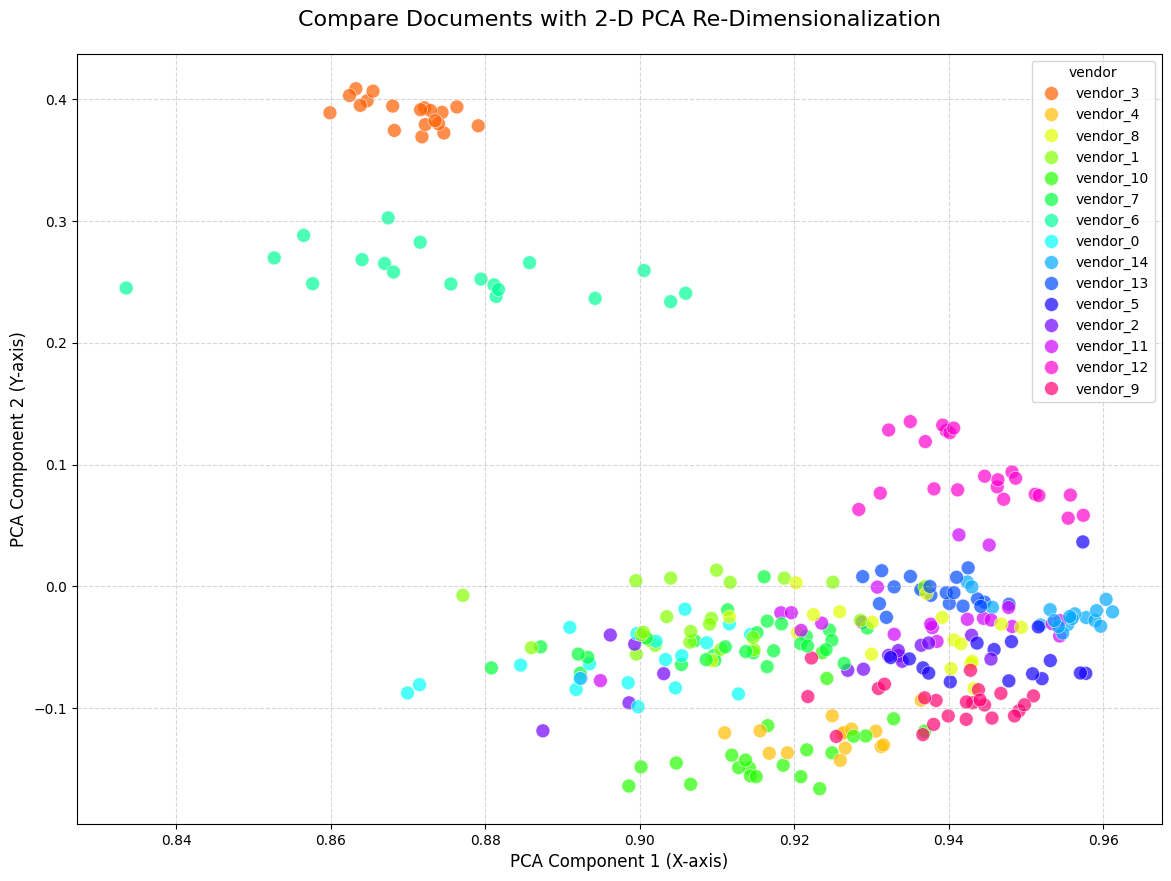

In [131]:
pca_predictions['pca_x'] = pca_predictions['pca_embedding'].apply(lambda emb: emb[0])
pca_predictions['pca_y'] = pca_predictions['pca_embedding'].apply(lambda emb: emb[1])

num_vendors = pca_predictions['vendor'].nunique()
palette = sns.color_palette("hsv", num_vendors)

plt.figure(figsize=(14, 10))
plt.title("Compare Documents with 2-D PCA Re-Dimensionalization", fontsize=16, pad=20)
plt.xlabel("PCA Component 1 (X-axis)", fontsize=12)
plt.ylabel("PCA Component 2 (Y-axis)", fontsize=12)
plt.legend(title='Vendor', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True, linestyle='--', alpha=0.5)

sns.scatterplot(
    data=pca_predictions,
    x='pca_x',
    y='pca_y',
    hue='vendor',       # Color points by vendor
    palette=palette,    # Color palette to use
    s=100,              # Size of the points
    alpha=0.7,          # Transparency of the points
    edgecolor='w',      # Edge color for points, can make them pop
    linewidth=0.5
)

plt.show()


### Get Predicted Values For Vendor Averages

The average embeddings for each vendor can also be used to get predicted values in the new 2-D space created with PCA.

In [132]:
%%bigquery pca_predictions_vendors
SELECT vendor, ml_generate_embedding_result as pca_embedding
FROM ML.GENERATE_EMBEDDING(
    MODEL `statmike-mlops-349915.solution_prototype_document_processing.pca_known_authentic`,
    (SELECT vendor, average_embedding as embedding FROM `statmike-mlops-349915.solution_prototype_document_processing.known_authenticity_vendor_info`)
)

Query is running:   0%|          |

Downloading:   0%|          |

In [133]:
pca_predictions_vendors

,vendor,pca_embedding
0,vendor_10,"[0.9178327479634066, -0.1350023941273454]"
1,vendor_8,"[0.9330019851551298, -0.039676192430357055]"
2,vendor_2,"[0.9205214538975607, -0.06302865279216188]"
3,vendor_11,"[0.936220056871974, -0.02484653048590446]"
4,vendor_12,"[0.9434141966815296, 0.0932650154847365]"
5,vendor_3,"[0.8699266163416692, 0.38896866534404845]"
6,vendor_0,"[0.8979579495098439, -0.06193507819414718]"
7,vendor_4,"[0.9249705007834251, -0.12340131707758092]"
8,vendor_7,"[0.9114213467673733, -0.047699044822380986]"
9,vendor_14,"[0.9543815349269024, -0.022646221563400896]"


### Visualize PCA Predictions Of Embeddings

Color coded by vendor.

/tmp/ipykernel_25252/562839296.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Vendor', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


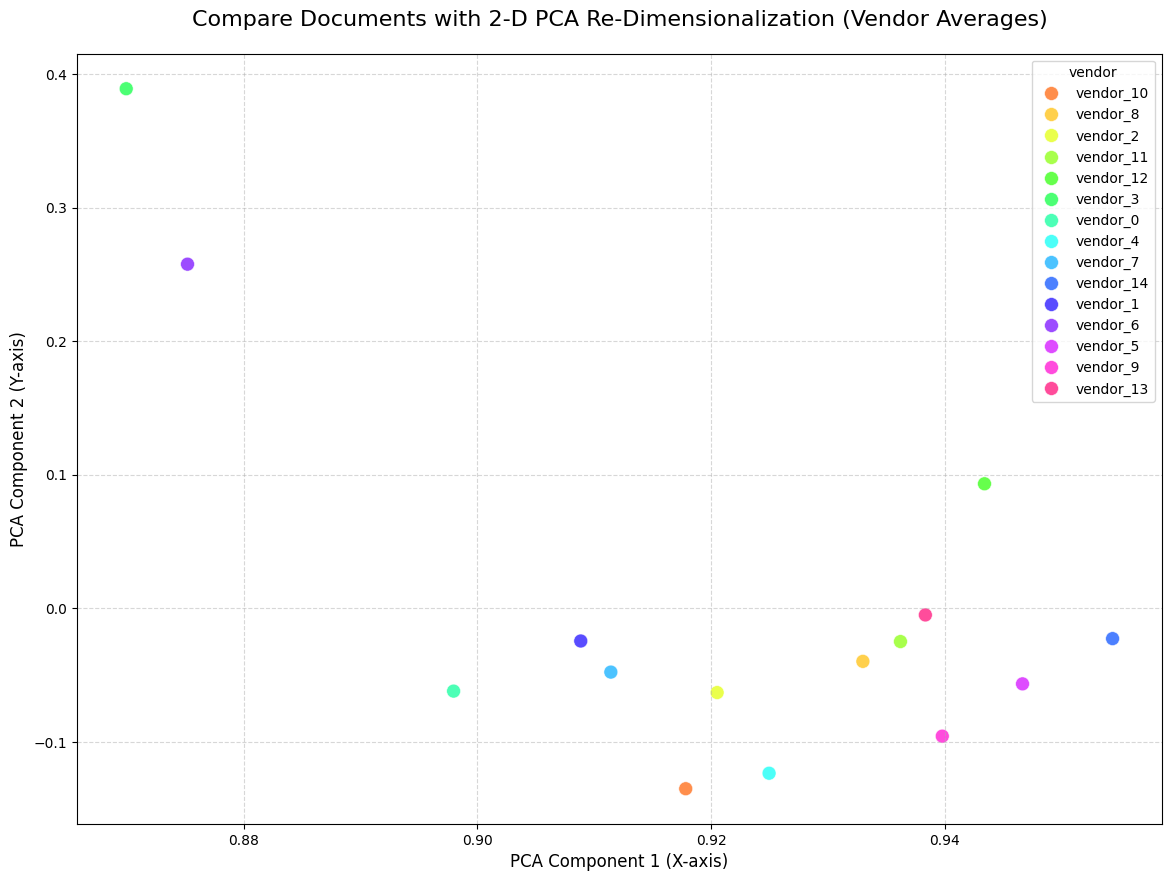

In [134]:
pca_predictions_vendors['pca_x'] = pca_predictions_vendors['pca_embedding'].apply(lambda emb: emb[0])
pca_predictions_vendors['pca_y'] = pca_predictions_vendors['pca_embedding'].apply(lambda emb: emb[1])

num_vendors = pca_predictions_vendors['vendor'].nunique()
palette = sns.color_palette("hsv", num_vendors)

plt.figure(figsize=(14, 10))
plt.title("Compare Documents with 2-D PCA Re-Dimensionalization (Vendor Averages)", fontsize=16, pad=20)
plt.xlabel("PCA Component 1 (X-axis)", fontsize=12)
plt.ylabel("PCA Component 2 (Y-axis)", fontsize=12)
plt.legend(title='Vendor', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True, linestyle='--', alpha=0.5)

sns.scatterplot(
    data=pca_predictions_vendors,
    x='pca_x',
    y='pca_y',
    hue='vendor',       # Color points by vendor
    palette=palette,    # Color palette to use
    s=100,              # Size of the points
    alpha=0.7,          # Transparency of the points
    edgecolor='w',      # Edge color for points, can make them pop
    linewidth=0.5
)

plt.show()


### Anomaly Deteciton With PCA

The PCA model can be directly uses with the [ML.DETECT_ANOMALIES](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-detect-anomalies#pca_model) function to detect anomalies.  This is done by also setting a contamination level as the rate of anomalouse records in the the training data - 0% in this case where the model was trained on known authentic documents.


In [145]:
%%bigquery
SELECT *
FROM ML.DETECT_ANOMALIES(
    MODEL `statmike-mlops-349915.solution_prototype_document_processing.pca_known_authentic`,
    STRUCT(0.0 AS contamination),
    (SELECT vendor, embedding FROM `statmike-mlops-349915.solution_prototype_document_processing.known_authenticity`)
)
WHERE is_anomaly = True

Query is running:   0%|          |

Downloading: |          |

,is_anomaly,mean_squared_error,vendor,embedding


---
## Do More

This is just the beginning of using embeddings to classify and evaluate documents based on similarity.  These concepts can be expanded with ideas like:
- Calculate the average and standard deviation of pairwise distance between documents within vendors.  This distribution information can be used to evalaute new documents fit within the vendors documents.
- Calcualte the average and standard deviation of distances between documents and the vendors centroid (average embedding).  This also serves as an evaluation point for new documents fit within the vendors documents.

As the size of this solution grows the efficiency of vector search can be increase through the use of [Vector Indexes](https://cloud.google.com/bigquery/docs/vector-search-intro).  Depending on how the workflow grows there are a number of vector database options on Google Cloud - [See a comparison here](../../../Applied%20GenAI/Retrieval/readme.md).